In [57]:
import requests
import pandas as pd
import numpy as np
import cvxpy as cp
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# OKX API 端点
BASE_URL = "https://www.okx.com/api/v5"

def get_okx_klines(instId="ETH-USDT", bar="1D", limit=101):
    url = f"{BASE_URL}/market/candles"
    params = {"instId": instId, "bar": bar, "limit": limit}
    response = requests.get(url, params=params)
    data = response.json()

    if "data" in data:
        df = pd.DataFrame(data["data"], columns=[
            "timestamp", "open", "high", "low", "close", "volume", "volCcy", "vol", "trades"
        ])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.set_index("timestamp", inplace=True)
        df = df.astype(float)
        return df
    else:
        print("❌ 获取数据失败:", data)
        return None

# 交易对列表
symbols = ["BTC-USDT", "ETH-USDT", "SOL-USDT", "BNB-USDT", "XRP-USDT", "ADA-USDT", "DOGE-USDT", "DOT-USDT"]
data_dict = {}
W1 = []
W2 = []
actual_portfolio_return1 = []
actual_portfolio_return2 = []

for kkk in tqdm(range(10)):
        # 获取所有交易对数据
    for symbol in symbols:
        df = get_okx_klines(symbol, "1D", 101)
        if df is not None:
            data_dict[symbol] = df["close"]
    
    # 组合成 DataFrame
    market_data = pd.DataFrame(data_dict)
    market_data.dropna(inplace=True)
    returns = market_data.pct_change().dropna()
    train_data = returns.iloc[:-1]  # 前 100 天的收益数据
    test_data = returns.iloc[-1:]  # 仅最后一天的数据
    test_data = test_data.to_numpy().reshape(-1, 1)
    
    # **修复 `reshape` 错误**
    expected_returns = np.mean(train_data, axis=0).to_numpy().reshape(-1, 1)  # **转换为 NumPy**
    cov_matrix = np.cov(train_data.T) + 1e-6 * np.eye(len(symbols))
    
    # 定义优化变量（资产权重）
    W = cp.Variable((len(symbols), 1))  # 确保是列向量
    
    # 目标函数：最大化收益 - 风险
    risk_aversion = 0.5
    objective = cp.Maximize(cp.matmul(expected_returns.T, W) - risk_aversion * cp.quad_form(W, cov_matrix))
    
    # 约束条件
    constraints = [
        cp.sum(W) == 0,
        W >= -1,
        W <= 1,
    ]
    
    # 求解优化问题
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    
    # 输出优化结果
    if problem.status not in ["infeasible", "unbounded"]:
        print("\n📈 最优交易对权重分配:")
        for i, symbol in enumerate(symbols):
            print(f"{symbol}: {W.value[i][0]:.4f}")
    else:
        print("❌ 优化问题无解")
    
    W1.append(W)
    
    # **🚀 1. 机器学习预测收益（优化 LSTM）**
    class LSTMModel(nn.Module):
        def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
            super(LSTMModel, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
    
        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h0, c0))
            return self.fc(out[:, -1, :])
    
    def predict_lstm(series):
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
        seq_length = 50 
        X, y = [], []
        for i in range(len(scaled_data) - seq_length - 1):
            X.append(scaled_data[i:i + seq_length])
            y.append(scaled_data[i + seq_length])
    
        X, y = np.array(X), np.array(y)
        X = X.reshape(X.shape[0], X.shape[1], 1)  # **确保 LSTM 输入形状正确**
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # **y 也要 reshape**
    
        # 80% 训练，20% 测试
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
    
        model = LSTMModel()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        best_loss = float("inf")
        best_model_state = None
    
        for epoch in range(100):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)  # **确保输入是 3D**
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
    
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_model_state = model.state_dict().copy()
    
        model.load_state_dict(best_model_state)
    
        # 预测下一步
        with torch.no_grad():
            X_pred = torch.tensor(scaled_data[-seq_length:].reshape(1, seq_length, 1), dtype=torch.float32)
            future_pred = model(X_pred).detach().numpy()
    
        return scaler.inverse_transform(future_pred)[0][0]
    
    expected_returns = np.mean(train_data, axis=0).to_numpy().reshape(-1, 1)  # **转换为 NumPy**
    cov_matrix = np.cov(train_data.T) + 1e-6 * np.eye(len(symbols))
    predicted_returns = np.array([predict_lstm(train_data[symbol]) for symbol in symbols]).reshape(-1, 1)
    
    
    # **🚀 3. 传统均值-方差优化**
    W = cp.Variable((len(symbols), 1))
    risk_aversion = 1
    
    objective = cp.Maximize(cp.matmul((0.8*expected_returns + 0.2*predicted_returns).T, W) - risk_aversion * cp.quad_form(W, cov_matrix))
    constraints = [cp.sum(W) == 0, W >= -1, W <= 1]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    
    # **🚀 6. 输出优化结果**
    
    # 输出优化结果
    if problem.status not in ["infeasible", "unbounded"]:
        print("\n📈 最优交易对权重分配:")
        for i, symbol in enumerate(symbols):
            print(f"{symbol}: {W.value[i][0]:.4f}")
    else:
        print("❌ 优化问题无解")
    
    W2.append(W) 
    actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
    actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
    

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8576
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8575
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 10%|█         | 1/10 [00:10<01:31, 10.19s/it]


📈 最优交易对权重分配:
BTC-USDT: 1.0000
ETH-USDT: -1.0000
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -0.9044
ADA-USDT: -0.9116
DOGE-USDT: 1.0000
DOT-USDT: 0.8160


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8555
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8555
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 20%|██        | 2/10 [00:20<01:20, 10.05s/it]


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 0.7220
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -0.9301
ADA-USDT: -0.7918
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8570
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8569
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 30%|███       | 3/10 [00:30<01:10, 10.09s/it]


📈 最优交易对权重分配:
BTC-USDT: -0.7773
ETH-USDT: 1.0000
SOL-USDT: -0.1080
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.1147
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8552
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8551
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 40%|████      | 4/10 [00:40<01:01, 10.18s/it]


📈 最优交易对权重分配:
BTC-USDT: 0.3607
ETH-USDT: -1.0000
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.3606
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8510
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8510
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 50%|█████     | 5/10 [00:51<00:51, 10.28s/it]


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: -1.0000
SOL-USDT: 1.0000
BNB-USDT: -0.2652
XRP-USDT: -1.0000
ADA-USDT: 0.8167
DOGE-USDT: 1.0000
DOT-USDT: 0.4485


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8517
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8517
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 60%|██████    | 6/10 [01:01<00:41, 10.27s/it]


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -1.0000
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8501
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8501
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 70%|███████   | 7/10 [01:12<00:31, 10.44s/it]


📈 最优交易对权重分配:
BTC-USDT: 1.0000
ETH-USDT: -0.8095
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: 0.8094
DOGE-USDT: 1.0000
DOT-USDT: -1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8515
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8515
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 80%|████████  | 8/10 [01:22<00:20, 10.46s/it]


📈 最优交易对权重分配:
BTC-USDT: 0.4996
ETH-USDT: 1.0000
SOL-USDT: -1.0000
BNB-USDT: -0.7846
XRP-USDT: -0.9386
ADA-USDT: -0.7764
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8530
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8530
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
 90%|█████████ | 9/10 [01:32<00:10, 10.39s/it]


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 1.0000
BNB-USDT: -0.5859
XRP-USDT: -1.0000
ADA-USDT: 0.5859
DOGE-USDT: 1.0000
DOT-USDT: -1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:24: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsin


📈 最优交易对权重分配:
BTC-USDT: -1.0000
ETH-USDT: 1.0000
SOL-USDT: 0.8508
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8508
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:176: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return1.append(float(test_data.T @ W1[-1].value))
C:\Users\92476\AppData\Local\Temp\ipykernel_18724\3304868075.py:177: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_portfolio_return2.append(float(test_data.T @ W2[-1].value))
100%|██████████| 10/10 [01:42<00:00, 10.30s/it]


📈 最优交易对权重分配:
BTC-USDT: 0.8643
ETH-USDT: -1.0000
SOL-USDT: 1.0000
BNB-USDT: -1.0000
XRP-USDT: -1.0000
ADA-USDT: -0.8643
DOGE-USDT: 1.0000
DOT-USDT: 1.0000


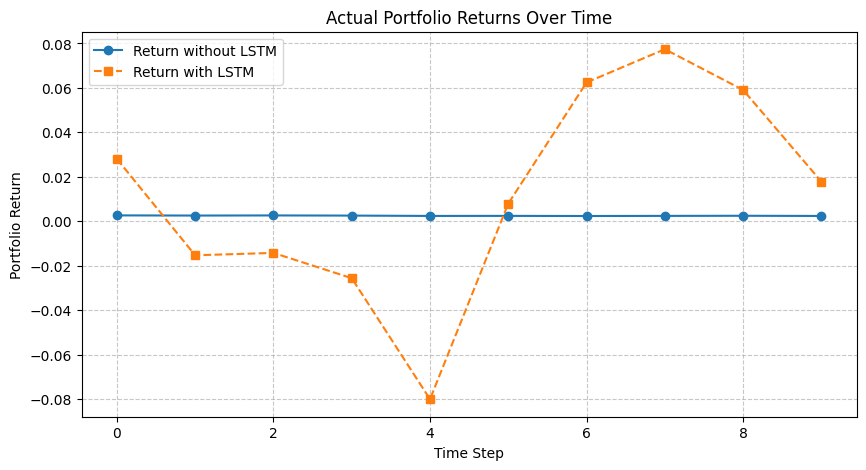

In [58]:
import matplotlib.pyplot as plt

# 假设 actual_portfolio_return1 和 actual_portfolio_return2 已经计算好
plt.figure(figsize=(10, 5))

# 绘制实际收益曲线
plt.plot(actual_portfolio_return1, label="Return without LSTM", marker='o', linestyle='-')
plt.plot(actual_portfolio_return2, label="Return with LSTM", marker='s', linestyle='--')

# 添加标题和标签
plt.xlabel("Time Step")
plt.ylabel("Portfolio Return")
plt.title("Actual Portfolio Returns Over Time")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)

# 显示图表
plt.show()


In [47]:
actual_portfolio_return1

[-0.0006447191248090955,
 -0.000622285116908261,
 -0.0006156035281524586,
 -0.0005363461102101119,
 -0.0004911176552872265,
 -0.0003977921931047901,
 -0.0006127543440945793,
 -0.0005604219585027548,
 -0.0005912623932183281,
 -0.000561143999375624]

In [59]:
W1[-1].value

array([[-1.00000361],
       [ 0.99999681],
       [ 0.8507805 ],
       [-1.00000744],
       [-0.99999797],
       [-0.85076493],
       [ 0.99999838],
       [ 0.99999828]])

In [60]:
W2[-1].value

array([[ 0.86429004],
       [-0.99999845],
       [ 1.00000097],
       [-0.99999956],
       [-0.99999745],
       [-0.8642969 ],
       [ 1.00000129],
       [ 1.00000005]])